## Part 3 : Would players be better now ?

In [1]:
import os
import pandas as pd
import scipy.stats as stats

import networkx as nx

from src.utils.embeddings_utils import *
from src.utils.path_utils import *

DATA = os.path.join('data')
ARTICLE_TXT_PATH = os.path.join('data', '2007', 'plain_text_articles')
PATH_2007 = os.path.join('data', '2007')
PATH_2024 = os.path.join('data', '2024')

c:\Users\Anasse\miniconda3\envs\ada\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Player Path Analysis

#### Path unfinished

Let's determine whether an unfinished path in 2007 could have been completed back then (i.e., if the player was close to reaching the target) and compare it to the 2024 Wikipedia link structure to assess if the player could now finish the game more quickly in 2024 than in 2007.

In [2]:
links2007 = pd.read_csv(os.path.join(PATH_2007, 'links.tsv'), sep='\t', comment='#', names=['linkSource', 'linkTarget'])
links2024 = pd.read_csv(os.path.join(PATH_2024, 'links2024.csv'), comment='#', names=['linkSource', 'linkTarget'])
path_unfinished = pd.read_csv(os.path.join(PATH_2007, 'paths_unfinished.tsv'), sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'], usecols=['hashedIpAddress', 'durationInSec', 'path', 'target', 'type'])

In [3]:
# remove path with only one element -> not considered as an attempt
# get path length
path_unfinished['path_length'] = path_unfinished['path'].apply(lambda x: len(x.split(';')))
path_unfinished = path_unfinished[path_unfinished['path_length'] > 3]
path_unfinished.head()

,hashedIpAddress,durationInSec,path,target,type,path_length
5,131600803df4895e,2009,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,timeout,4
6,486bb79910fe9dd2,1932,Mind;Christianity;Europe;Renaissance;Ancient_G...,Scouting,timeout,7
7,6d136e371e42474f,175,4-2-0;United_States;Agriculture;Sugar;Australia,Cane_Toad,restart,5
9,6d136e371e42474f,2006,Logic;Computer_science;Science;Physical_scienc...,Moon_landing,timeout,9
10,430ca00e7f5303b7,1976,Battle_of_Gettysburg;Washington%2C_D.C.;United...,Ostrich,timeout,7


In [4]:
path_unfinished.describe()['path_length']

count    13273.000000
mean         8.147367
std          6.571635
min          4.000000
25%          5.000000
50%          6.000000
75%          9.000000
max        235.000000
Name: path_length, dtype: float64

Let's process our unfinished path to determine whether, theoretically, a player could have completed the game in 2007 and to analyze whether finishing the game is faster in 2024 compared to 2007.

Data format:
| path | target | final_link | distance |
|------|--------|------------|----------|
|path of the player      |   target to reach     |      final link reached before going to target (same as path if target cannot be reached)      |     number of click earned (equal -1 if the path is not possible based on our data)    |

In [5]:
df_unfinished = create_comparison_unfinished_path(DATA, path_unfinished, links2007, links2024, load=True)
print(df_unfinished.shape)
df_unfinished.head()

(19661, 6)


,path,target,final_link2007,final_link2024,distance2007,distance2024
0,Malawi;Democracy;Alexander_the_Great,First_Crusade,Alexander_the_Great,Alexander_the_Great,0,0
1,Paraguay;Bolivia,Mount_St._Helens,Bolivia,Bolivia,0,0
2,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,Yangtze_River,NaN,0,-1
3,Mind;Christianity;Europe;Renaissance;Ancient_G...,Scouting,Asia,Asia,0,0
4,4-2-0;United_States;Agriculture;Sugar;Australia,Cane_Toad,Australia,Australia,0,0


In [6]:
# remove all path with distance = -1 (invalid path and no possible comparison)
df_ttest = df_unfinished[(df_unfinished['distance2007'] != -1) &
                       (df_unfinished['distance2024'] != -1)]
print(df_ttest.shape)
df_ttest.describe()

(15335, 6)


,distance2007,distance2024
count,15335.000000,15335.000000
mean,0.065145,0.056798
std,0.732249,0.376145
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,61.000000,12.000000


In [7]:
from scipy.stats import ttest_ind
ttest_ind(df_ttest['distance2007'], df_ttest['distance2024'])

TtestResult(statistic=1.2556186478097844, pvalue=0.2092638333352878, df=30668.0)

p-value > 0.05, we can not say that average expected value of the distances is different between 2007 and 2024 for the unfinished paths.

In [8]:
print_result_comparison_paths(df_unfinished)

==== Path possible ? ====
Path won't change between 2007 and 2024 : 14537
Path impossible to do in 2024 but possible in 2007 : 4324
Path impossible to do in 2007 and 2024 : 2
Path still possible in 2024 : 15335

==== Path faster or slower in 2024 ? ====
Path faster in 2024 than 2007: 423
Path slower or equal in 2024 than 2007: 375


Path not possible in 2007 ? This is strange... let's make more analysis

In [9]:
for i, data in df_unfinished[df_unfinished.distance2007 == -1].iterrows():
    testpath = fix_path(data['path'])

    for i in range(len(testpath) - 1):
        output = links2007[ (links2007.linkSource == testpath[i]) & (links2007.linkTarget == testpath[i+1])]
        if output.empty:
            print(f'Link {unquote(testpath[i])} -> {unquote(testpath[i+1])} does not exist in links2007')

Link Finland -> Åland does not exist in links2007
Link Technology -> Wikipedia_Text_of_the_GNU_Free_Documentation_License does not exist in links2007


By examining the Wikispeedia page for [Finland](https://dlab.epfl.ch/wikispeedia/play/?article=Finland), we can confirm the presence of a link to Åland. Same for Technology to Wikipedia_Text_of_the_GNU_Free_Documentation_License... 

However, these links are missing in our dataset `links2007`.

In [10]:
# df_unfinished2 = df_unfinished[(df_unfinished['distance2007'] != -1) &
#                        (df_unfinished['distance2024'] != -1)]

# df_data = df_unfinished2.copy()

# compare_shortened_path_plot(df_data,"Comparison of shortened unfinished paths in 2007 vs 2024")

#### Path finished

In [11]:
path_finished = pd.read_csv(os.path.join(PATH_2007, 'paths_finished.tsv'), sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
path_finished['target'] = path_finished['path'].apply(lambda x: x.split(';')[-1])
path_finished['path_length'] = path_finished['path'].apply(lambda x: len(x.split(';')))
path_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,target,path_length
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,African_slave_trade,9
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,African_slave_trade,5
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,African_slave_trade,8
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,Greece,4
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,John_F._Kennedy,7


In [12]:
path_finished.describe()['path_length']

count    51318.000000
mean         6.757434
std          4.680718
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max        435.000000
Name: path_length, dtype: float64

Let's check if the rating difficulty of the game is correlated with the number of clicks needed to finish the game. I drop the NaN values instead of imputing them to have an unbiased result for the correlation.

In [13]:
stats.pearsonr(path_finished.dropna(subset=['rating'])['path_length'], 
               path_finished.dropna(subset=['rating'])['rating'])

PearsonRResult(statistic=0.4037485699951087, pvalue=0.0)

In [14]:
stats.spearmanr(path_finished.dropna(subset=['rating'])['path_length'], 
                path_finished.dropna(subset=['rating'])['rating'])

SignificanceResult(statistic=0.5539921093665069, pvalue=0.0)

Significant correlation between the path length and rating of the player.

Let's process our finished path to determine whether, theoretically, a player could have completed the game earlier in 2007 and to analyze whether finishing the game is faster in 2024 compared to 2007.

Data format:
| path | target | final_link | distance |
|------|--------|------------|----------|
|path of the player      |   target to reach     |      final link reached before going to target (same as path if target cannot be reached)      |     number of click earned (equal -1 if the path is not possible based on our data)    |

In [15]:
df_finished = create_comparison_finished_path(DATA, path_finished, links2007, links2024, load=True)
print(df_unfinished.shape)
df_unfinished.head()

(19661, 6)


,path,target,final_link2007,final_link2024,distance2007,distance2024
0,Malawi;Democracy;Alexander_the_Great,First_Crusade,Alexander_the_Great,Alexander_the_Great,0,0
1,Paraguay;Bolivia,Mount_St._Helens,Bolivia,Bolivia,0,0
2,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,Yangtze_River,NaN,0,-1
3,Mind;Christianity;Europe;Renaissance;Ancient_G...,Scouting,Asia,Asia,0,0
4,4-2-0;United_States;Agriculture;Sugar;Australia,Cane_Toad,Australia,Australia,0,0


In [16]:
# remove all path with distance = -1 (invalid path and no possible comparison)
df_ttest = df_finished[(df_finished['distance2007'] != -1) &
                       (df_finished['distance2024'] != -1)]

df_ttest.describe()

,distance2007,distance2024
count,18636.000000,18636.000000
mean,0.170745,0.294162
std,0.648322,0.733330
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,25.000000,27.000000


In [17]:
stats.ttest_ind(df_ttest['distance2007'], df_ttest['distance2024'])

TtestResult(statistic=-17.212631239901707, pvalue=3.8502960068475356e-66, df=37270.0)

pvalue < 0.05, we reject the null hypothesis that the two distributions have identical average expected value. 

In [18]:
print_result_comparison_paths(df_finished)

==== Path possible ? ====
Path won't change between 2007 and 2024 : 14020
Path impossible to do in 2024 but possible in 2007 : 32677
Path impossible to do in 2007 and 2024 : 2
Path still possible in 2024 : 18636

==== Path faster or slower in 2024 ? ====
Path faster in 2024 than 2007: 2719
Path slower or equal in 2024 than 2007: 1900


#### Plot

In [19]:
# remove all path with distance = -1 (no possible comparison)
df_unfinished2 = df_unfinished[(df_unfinished['distance2007'] != -1) &
                           (df_unfinished['distance2024'] != -1)]

df_finished2 = df_finished[(df_finished['distance2007'] != -1) &
                           (df_finished['distance2024'] != -1)]

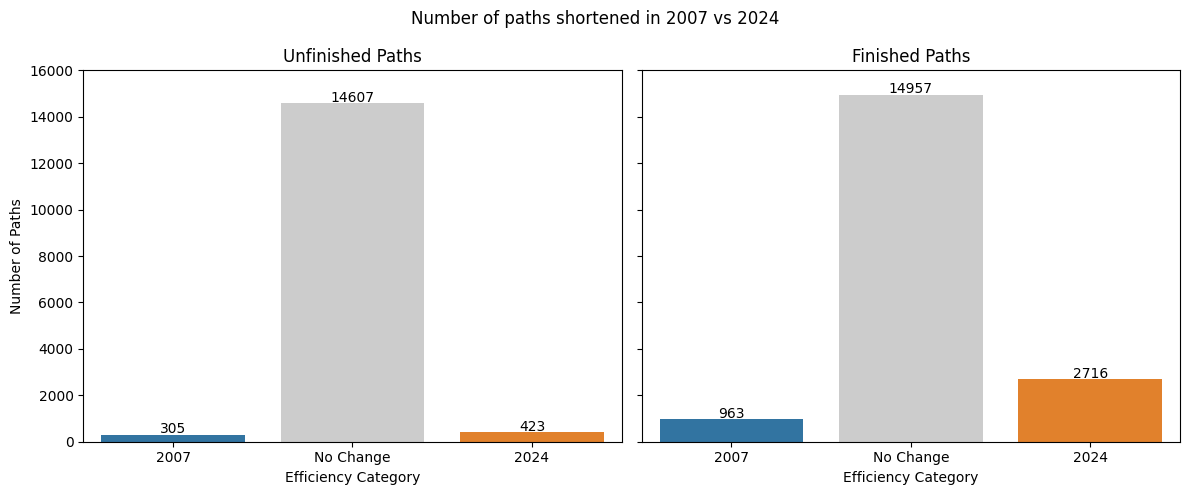

In [20]:
plot_comarison_length_path(df_finished2.copy(), df_unfinished2.copy())

Globally, we observe that for the most of the game player there is no difference in the number of game shortened between 2007 and 2024. But we can see that the 2024 version shortened more path than 2007 whether for unfinished and finished paths. This might suggests that the 2024 version has the potential to make players stronger ? That said, let's not jump to conclusions and take a closer look...

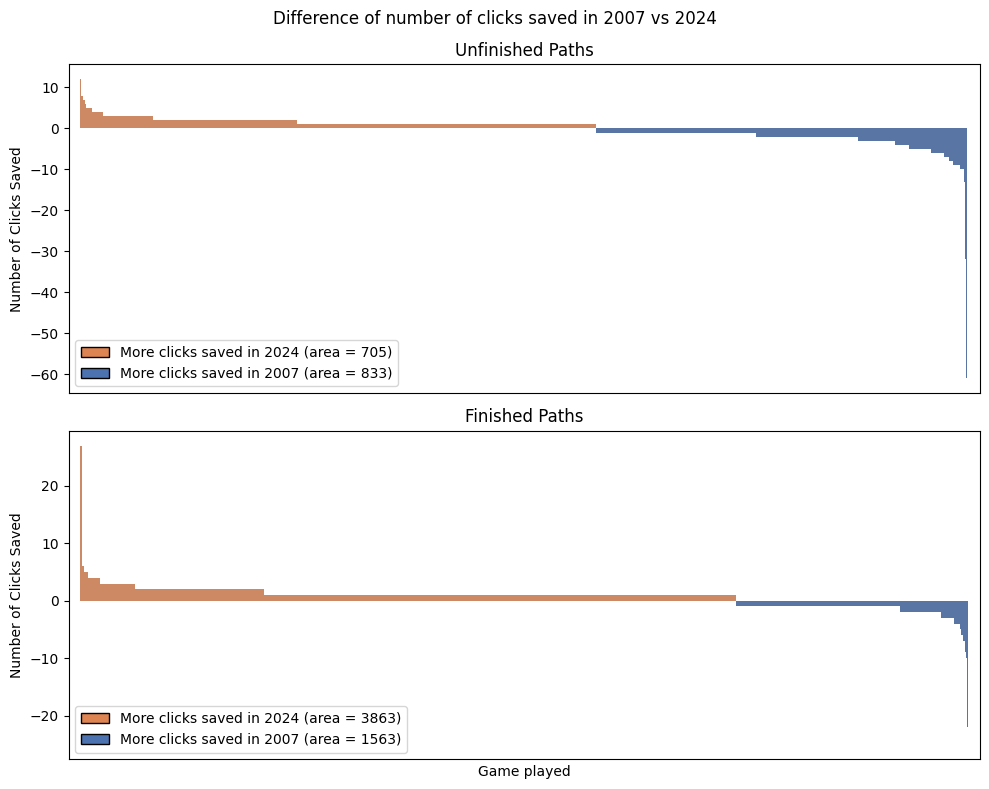

In [21]:
plot_comparison_clicks_saved(df_finished2.copy(), df_unfinished2.copy(), "Difference of number of clicks saved in 2007 vs 2024")

Looking at the number of clicks saved, it turns out 2007 does better for unfinished paths compared to 2024, even though it impacts fewer paths overall (305 paths for 833 clicks saved in 2007 versus 423 paths for 705 clicks saved in 2024).

On the other hand, for finished paths, 2024 clearly takes the lead, with 3,863 clicks saved across 2,716 paths, compared to just 1,000 clicks saved for 1,000 paths in 2007.

So, it seems like 2024 could potentially help players finish the game faster than 2007.

### Structural Comparison : 2007 vs. 2024

In [22]:
articles2007 = pd.read_csv(os.path.join(PATH_2007, 'articles.tsv'), sep='\t', comment='#', names=['article'])
articles2007_unquote = articles2007.copy()
articles2007_unquote['article'] = articles2007['article'].apply(unquote)

links2007_unquote = links2007.copy()
links2007_unquote['linkSource'] = links2007_unquote['linkSource'].apply(unquote)
links2007_unquote['linkTarget'] = links2007_unquote['linkTarget'].apply(unquote)

links2024_unquote = links2024.copy()
links2024_unquote['linkSource'] = links2024_unquote['linkSource'].apply(unquote)
links2024_unquote['linkTarget'] = links2024_unquote['linkTarget'].apply(unquote)

common_article = set(links2007_unquote['linkSource']).intersection(set(links2024_unquote['linkSource']))

In [23]:
# create a graph with links dataframe
G_2007 = nx.DiGraph()
G_2007.add_nodes_from(articles2007_unquote['article'])

for i, row in links2007_unquote.iterrows():
    if row['linkSource'] in G_2007.nodes and row['linkTarget'] in G_2007.nodes:
        G_2007.add_edge(row['linkSource'], row['linkTarget'])  

In [24]:
G_2024 = nx.DiGraph()
G_2024.add_nodes_from(articles2007_unquote['article'])

for i, row in links2024_unquote.iterrows():
    if row['linkSource'] in G_2024.nodes and row['linkTarget'] in G_2024.nodes:
        G_2024.add_edge(row['linkSource'], row['linkTarget'])

#### Similarity

How can we compare the efficiency of Wikipedia's structure in 2007 and 2024?

One approach is to evaluate the similarity between articles. For each article, we calculate its similarity with every other article. Then, we compute a similarity score for each article, which corresponds to the average similarity with all the articles it links to (outgoing links).

$$ \text{similarity score}(article) = \frac{1}{n} \sum_{i=1}^{n} \text{similarity}(article, article_i) $$

where $n$ is the number of outgoing links of the article, and $article_i$ is the $i$-th article linked to by the article.

How compute the similarity between two articles? 

The main task is to find a way to represent articles in a vector space. we decide to use two differents approaches:

- `Node2Vec`: We use the node2vec algorithm to compute the similarity between articles. Node2Vec is an algorithm that learns continuous feature representations for nodes in networks. We use the node2vec implementation from the `node2vec` library.

- `Sentence-BERT`: We use the Sentence-BERT model to represent article content in a vector space. Sentence-BERT is a modification of the BERT network that is trained to derive semantically meaningful sentence embeddings. We use the `sentence-transformers` library to compute the similarity between articles.

Node2vec focus more on the structure of the graph, while Sentence-BERT focus more on the content of the articles.

Then, our similarity score is the average of the similarity scores obtained with the two methods.

$$ \text{similarity}(a_1, a_2) = \frac{1}{2} \left( \text{similarity}(a_1, a_2)_{\text{Node2Vec}} + \text{similarity}(a_1, a_2)_{\text{Sentence-BERT}} \right) $$

where $a_1$ and $a_2$ are two articles.

First, we need to get the article content from wikipedia (only summary). 

- 2007 : We use the plaintext_articles data to get the content of the articles.

- 2024 : We use the Wikipedia API to get the content of the articles.

##### 2007

In [25]:
summaries2007 = get_summaries2007(ARTICLE_TXT_PATH, PATH_2007, 'summaries2007.csv')
summaries2007.head()

,article,content
0,Áedán_mac_Gabráin,Satellite image of northern Britain and Irelan...
1,Åland,Landskapet Åland\n Ahvenanmaan maakunta\n ...
2,Édouard_Manet,Articles with similar titles include Claude Mo...
3,Éire,This is a featured article. Click here for mor...
4,Óengus_I_of_the_Picts,Óengus son of Fergus\n King of the Picts\n ...


##### 2024

In [26]:
article_name_2024 = pd.read_csv(os.path.join(PATH_2024, 'articles2024_name.csv'), names=['article'])
summaries2024 = get_summaries2024(article_name_2024, PATH_2024, 'summaries2024.csv')
summaries2024.head()

,article,content
0,10th_century,The 10th century was the period from 901 (repr...
1,11th_century,The 11th century is the period from 1001 (repr...
2,12th_century,The 12th century is the period from 1101 to 12...
3,13th_century,The 13th century was the century which lasted ...
4,14th_century,The 14th century lasted from 1 January 1301 (r...


##### Node2Vec & Sentence-BERT to measure and compare structural similarities

In [27]:
links2007_similarity, links2024_similarity = get_links_similarity(DATA, PATH_2007, PATH_2024, ARTICLE_TXT_PATH, article_name_2024, 
                                                                  G_2007, G_2024, links2007_unquote, links2024_unquote, load=True)

links2007_similarity.head()

,linkSource,linkTarget,n2v_similarity,sbert_similarity,similarity
0,Áedán_mac_Gabráin,Bede,0.585006,0.237665,0.411335
1,Áedán_mac_Gabráin,Columba,0.731949,0.429983,0.580966
2,Áedán_mac_Gabráin,Dál_Riata,0.731973,0.650527,0.691250
3,Áedán_mac_Gabráin,Great_Britain,0.655600,0.170070,0.412835
4,Áedán_mac_Gabráin,Ireland,0.656894,0.342100,0.499497


In [28]:
links2024_similarity.head()

,linkSource,linkTarget,n2v_similarity,sbert_similarity,similarity
0,Áedán_mac_Gabráin,Dál_Riata,0.881055,0.550868,0.715962
1,Áedán_mac_Gabráin,Columba,0.760585,0.457233,0.608909
2,Áedán_mac_Gabráin,Orkney,0.744174,0.278360,0.511267
3,Áedán_mac_Gabráin,Isle_of_Man,0.568829,0.396943,0.482886
4,Áedán_mac_Gabráin,Bede,0.586326,0.274804,0.430565


In [29]:
similarity_2007 = links2007_similarity.groupby('linkSource')[['n2v_similarity', 'sbert_similarity']].mean()
similarity_2024 = links2024_similarity.groupby('linkSource')[['n2v_similarity', 'sbert_similarity']].mean()

similarities = pd.merge(similarity_2007, similarity_2024, on='linkSource', suffixes=('_2007', '_2024'))
similarities.describe()

,n2v_similarity_2007,sbert_similarity_2007,n2v_similarity_2024,sbert_similarity_2024
count,4539.000000,4539.000000,4539.000000,4539.000000
mean,0.539606,0.225459,0.565896,0.239078
std,0.120540,0.102761,0.122095,0.087992
min,0.234105,-0.133736,-0.024988,-0.095537
25%,0.450327,0.154362,0.479622,0.180471
50%,0.522074,0.215350,0.551837,0.237080
75%,0.617628,0.284711,0.640587,0.294082
max,0.991188,0.688811,0.947322,0.628260


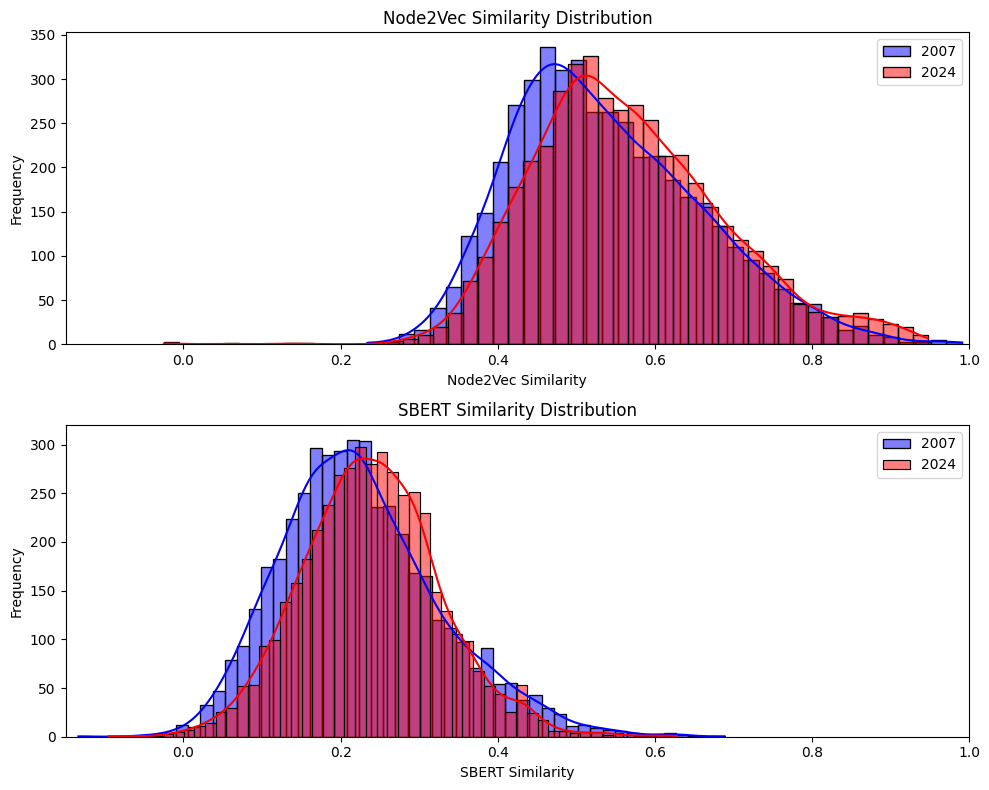

In [30]:
plot_similarity_distributions(similarities)

We can observe a slight improvement in the similarity for both structural and content-based similarity between articles in 2024 compared to 2007. The similarity between articles in 2024 is higher than in 2007, which indicates that the structure of Wikipedia has evolved to be more coherent and organized.

In [31]:
similarity_2007 = links2007_similarity.groupby('linkSource')['similarity'].mean()
similarity_2024 = links2024_similarity.groupby('linkSource')['similarity'].mean()

similarities = pd.merge(similarity_2007, similarity_2024, on='linkSource', suffixes=('_2007', '_2024'))
similarities.describe()

,similarity_2007,similarity_2024
count,4539.000000,4539.000000
mean,0.382532,0.402487
std,0.102174,0.094681
min,0.104964,-0.020964
25%,0.309238,0.337917
50%,0.367312,0.394595
75%,0.447471,0.458558
max,0.828664,0.752633


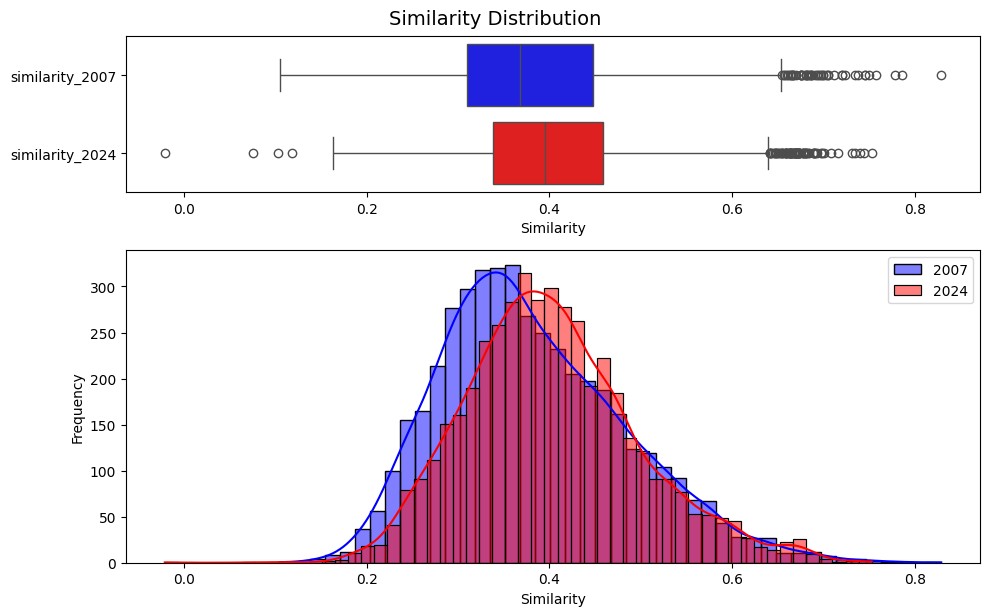

In [32]:
plot_similarity_distribution(similarities)

In [33]:
ttest_ind(similarities['similarity_2007'], similarities['similarity_2024'], alternative='less')

TtestResult(statistic=-9.651197194678133, pvalue=3.0957433459260986e-22, df=9076.0)

Again, we observe that the distribution of the combined similarity scores of articles in 2024 is slightly higher than in 2007. But is this difference significant? We perform a T-test to compare the two distributions. We choose a significance level of α=5% and we obtain a p-value < 0.05. Thus, that provides very strong evidence that the mean of the distribution of similarities of 2007 is less than the mean of the distribution of similarities of 2024.

The evolution of Wikipedia’s structure from 2007 to 2024 has led to an improvement in the similarity between articles. The structure of Wikipedia in 2024 is more coherent and organized than in 2007.